# Data Loading, Cleaning and Feature Selection
The following tasks are executed:
- Data is loaded from raw files
- Columnnames are fixed
- Columns get correct object type
- Class columns are put as the last columns
- Missing data is replaced by NaN
- Data characteristics are visualized
- Missing data is visualized
- Data is saved to a new, cleaned file as a df

## Parameters

In [58]:
#data_file = "02_Training_Data/omxs30_dataset.csv"
data_file = "03_Test_Prepared_Data/omxs30_test_dataset.csv"
print("Source path: ", data_file)

#image_save_directory = '02_Training_Data/images'
image_save_directory = '03_Test_Prepared_Data/images'
#filedataresultdirectory = '02_Training_Data'
filedataresultdirectory = '03_Test_Prepared_Data'

datatitle = 'OMXS30'

#filenameprefix = 'omxs30'
filenameprefix = 'omxs30_test'
filenameXsuffix = ''
filenameysuffix = '_LongTrend'

className = 'LongTrend'

missingValueModelPath = filedataresultdirectory + "/" + filenameprefix + "_missing_value_model.csv"
X_filename = filedataresultdirectory + "/" + filenameprefix + "_X" + filenameXsuffix + ".csv"
y_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + filenameysuffix + ".csv"
ylabel_filename = filedataresultdirectory + "/" + filenameprefix + "_y" + "_labels.csv"
X_filename_selected_feature_column = filedataresultdirectory + "/" + filenameprefix + "_X" + filenameXsuffix + "_selected_feature_columns.csv"
filename_timegraph = filedataresultdirectory + "/" + filenameprefix + "_timegraph" + ".csv"

print("Missing value path: ", missingValueModelPath)
print("Save features to X: ", X_filename)
print("Save features to y: ", y_filename)
print("Define y labels to ", ylabel_filename)
print("Selected feature column file name: ", X_filename_selected_feature_column)
print("Time graph path: ", filename_timegraph)

#To save time in the generation of test data and to skip the feature analysis, set this option to false. For training 
#data, set it to true.
#do_feature_analysis = True
skip_feature_analysis = True
skip_feature_selection = True
print("Feature analysis to be skipped: ", skip_feature_analysis)
print("Feature selection to be skipped: ", skip_feature_selection)

Source path:  03_Test_Prepared_Data/omxs30_test_dataset.csv
Missing value path:  03_Test_Prepared_Data/omxs30_test_missing_value_model.csv
Save features to X:  03_Test_Prepared_Data/omxs30_test_X.csv
Save features to y:  03_Test_Prepared_Data/omxs30_test_y_LongTrend.csv
Define y labels to  03_Test_Prepared_Data/omxs30_test_y_labels.csv
Selected feature column file name:  03_Test_Prepared_Data/omxs30_test_X_selected_feature_columns.csv
Time graph path:  03_Test_Prepared_Data/omxs30_test_timegraph.csv
Feature analysis to be skipped:  True
Feature selection to be skipped:  True


In [59]:
# Import libraries
#%matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.ticker import FuncFormatter, MaxNLocator
import DatavisualizationFunctions as vis
import DataSupportFunctions as sup

#Global settings
np.set_printoptions(precision=3)

#Suppress print out in scientific notiation
np.set_printoptions(suppress=True)

#Load skip cell kernel extension
#Source: https://stackoverflow.com/questions/26494747/simple-way-to-choose-which-cells-to-run-in-ipython-notebook-during-run-all
#%%skip True  #skips cell
#%%skip False #won't skip
#should_skip = True
#%%skip $should_skip
%load_ext skip_kernel_extension

The skip_kernel_extension extension is already loaded. To reload it, use:
  %reload_ext skip_kernel_extension


## Load dataset

In [60]:
#Load dataset
df = pd.read_csv(data_file, sep=';').set_index('id') #Set ID to be the data id
display(df.head(1))

#=== Get classes into a dict ===#
class_labels = dict(zip(df[className].unique(), list(range(1,len(df[className].unique())+1, 1))))
#Load class labels instead
df_y_classes = pd.read_csv(ylabel_filename, delimiter=';', header=None)
class_labels = sup.inverse_dict(df_y_classes.set_index(df_y_classes.columns[0]).to_dict()[1])
print("Loaded  classes from file", class_labels)

#=== Define classes manually ===#
#class_labels = {
#    0 : 'class1',
#    1 : 'class2'
#}

print(class_labels)


#=== Define index name ===#
#Define name if there is no index name

#df.index.name = 'id'

#=== Drop alternative y values ===#
df=df.drop(['1dTrend', '5dTrend', '20dTrend'], axis=1)

#=== Reorder columns to have the class as the last column if it is not done yet ===#
df = df[[c for c in df if c not in [className]] + [className]]

#=== Use only a subset header ===#
#header = ['Elevation', 'Aspect', 'Slope', 
#          'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
#          'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
#          'Horizontal_Distance_To_Fire_Points'] + \
#         ['Wilderness_Area_{:d}'.format(i) for i in range(4)] + \
#         ['Soil_Type_{:d}'.format(i) for i in range(40)] + \
#          ['Cover_type']
# header=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
#         'marital-status', 'occupation', 'relationship', 'race', 'sex', 
#         'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Income50K']
#df.columns = header

#=== rename colums ===#
#df.rename(columns={'model.year':'year'}, inplace=True)

#Rename columns with " "
df.columns = [x.replace(" ", "_") for x in df.columns]
df.columns = [x.replace("/", "-") for x in df.columns]

display(df.head(5))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,1dTrend,5dTrend,20dTrend,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
400,-0.003522,-0.005992,-0.006573,-0.016782,-0.020412,-0.031975,-0.032452,-0.027211,-0.033875,-0.035074,...,0.0,8,32,219,7,1,0,0,1,0


Loaded  classes from file {0: 'negative', 1: 'positive'}
{0: 'negative', 1: 'positive'}


,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
400,-0.003522,-0.005992,-0.006573,-0.016782,-0.020412,-0.031975,-0.032452,-0.027211,-0.033875,-0.035074,...,87.725927,31.673974,0.334551,0.00,8,32,219,7,1,0
401,-0.000844,-0.006427,-0.006441,-0.015985,-0.019097,-0.032834,-0.033579,-0.028324,-0.035232,-0.036156,...,87.125064,31.945192,0.271218,0.00,8,32,220,8,2,0
402,-0.002636,-0.007598,-0.010304,-0.018500,-0.021519,-0.037011,-0.037952,-0.032968,-0.040037,-0.040844,...,87.141026,30.244615,-1.700577,-1.00,8,32,221,9,3,0
403,0.004456,0.001849,-0.001233,-0.007684,-0.010759,-0.027983,-0.028706,-0.024109,-0.031330,-0.031816,...,85.895453,28.737115,-1.507500,-0.60,8,32,222,10,4,0
404,0.001557,0.005382,0.001923,-0.003167,-0.005846,-0.024314,-0.024914,-0.020768,-0.028075,-0.028246,...,83.046695,25.616731,-3.120385,-0.36,8,33,225,13,0,0


In [61]:
#Load original data for visualization
import matplotlib.dates as mdates
import datetime

df_timegraph = pd.read_csv(filename_timegraph, delimiter=';').set_index('id')
df_timegraph['Time'] = pd.to_datetime(df_timegraph['Time'])
df_timegraph['Time'].apply(mdates.date2num)
print("Loaded feature names for time graph={}".format(df_timegraph.columns))
print("X. Shape={}".format(df_timegraph.shape))
display(df_timegraph.head())

Loaded feature names for time graph=Index(['Time', 'High', 'Low', 'Close'], dtype='object')
X. Shape=(273, 4)


,Time,High,Low,Close
id,,,,
400,2018-08-07,1621.26,1610.52,1619.89
401,2018-08-08,1624.10,1614.73,1622.63
402,2018-08-09,1631.74,1618.72,1631.23
403,2018-08-10,1627.44,1613.39,1616.82
404,2018-08-13,1616.34,1607.81,1611.80


## Data Cleanup

In [62]:
print("feature columns: {}".format(df.columns[0:-1]))

feature columns: Index(['MA2Norm', 'MA5Norm', 'MA10Norm', 'MA18Norm', 'MA20Norm', 'MA40Norm',
       'MA50Norm', 'MA75Norm', 'MA100Norm', 'MA125Norm', 'MA150Norm',
       'MA175Norm', 'MA200Norm', 'MA225Norm', 'MA250Norm', 'MA275Norm',
       'MA300Norm', 'MA325Norm', 'MA350Norm', 'MA375Norm', 'MA400Norm',
       'MA2NormDiff', 'MA5NormDiff', 'MA10NormDiff', 'MA18NormDiff',
       'MA20NormDiff', 'MA40NormDiff', 'MA50NormDiff', 'MA75NormDiff',
       'MA100NormDiff', 'MA125NormDiff', 'MA150NormDiff', 'MA175NormDiff',
       'MA200NormDiff', 'MA225NormDiff', 'MA250NormDiff', 'MA275NormDiff',
       'MA300NormDiff', 'MA325NormDiff', 'MA350NormDiff', 'MA375NormDiff',
       'MA400NormDiff', 'RSI2', 'RSI5', 'RSI14', 'RSI20', 'RSI25',
       'Stoch_slowk13', 'Stoch_slowd8', 'MACD12_26_9', 'MACD12_26_9Diff',
       'MACD12_26_9DiffDirChange', 'month_of_year', 'week_of_year',
       'day_of_year', 'day_of_month', 'day_of_week'],
      dtype='object')


In [63]:
#Strip all string values to find the missing data
from pandas.api.types import is_string_dtype

for col in df.columns:
    if is_string_dtype(df[col]):
        print("Strip column {}".format(col))
        df[col]=df[col].str.strip()

In [64]:
#Replace values for missing data

#=== Replace all missing values with np.nan
for col in df.columns[0:-1]:
    df[col] = df[col].replace('?', np.nan)
    #df[col] = df[col].replace('unknown', np.nan)
    
print("Missing data in the data frame")
print(sum(df.isna().sum()))

Missing data in the data frame
0


In [65]:
#Get column types
print("Column types:")
print(df.dtypes)
print("\n")

Column types:
MA2Norm                     float64
MA5Norm                     float64
MA10Norm                    float64
MA18Norm                    float64
MA20Norm                    float64
MA40Norm                    float64
MA50Norm                    float64
MA75Norm                    float64
MA100Norm                   float64
MA125Norm                   float64
MA150Norm                   float64
MA175Norm                   float64
MA200Norm                   float64
MA225Norm                   float64
MA250Norm                   float64
MA275Norm                   float64
MA300Norm                   float64
MA325Norm                   float64
MA350Norm                   float64
MA375Norm                   float64
MA400Norm                   float64
MA2NormDiff                 float64
MA5NormDiff                 float64
MA10NormDiff                float64
MA18NormDiff                float64
MA20NormDiff                float64
MA40NormDiff                float64
MA50NormDiff  

## Get Data Characteristics

In [66]:
# Get number of samples
numSamples=df.shape[0]
print("Number of samples={}".format(numSamples))

# Get number of features
numFeatures=df.shape[1]-1
print("Number of features={}".format(numFeatures))

#Get the number of classes for the supervised learning
numClasses = df[className].value_counts().shape[0]
print("Number of classes={}".format(numClasses))

Number of samples=273
Number of features=57
Number of classes=2


## Analyse and Transform time series

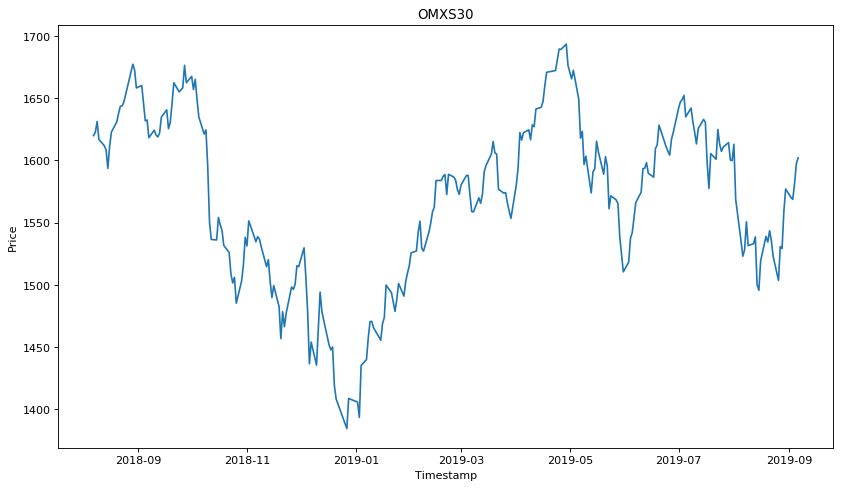

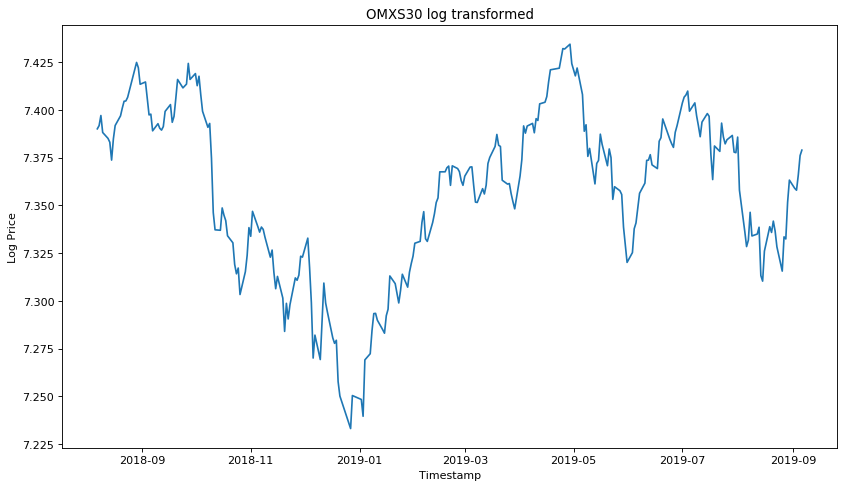

In [67]:
plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_timegraph['Time'],df_timegraph['Close']) #To get scatter plot, add 'o' as the last parameter
plt.title(datatitle)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.show()

plt.figure(num=None, figsize=(12.5, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_timegraph['Time'],np.log(df_timegraph['Close']))
plt.title(datatitle + ' log transformed')
plt.xlabel("Timestamp")
plt.ylabel("Log Price")
plt.show()

## Analyse the Features Individually

In [68]:
%%skip $skip_feature_analysis
# Print graphs for all features
for i, d in enumerate(df.dtypes):
    if is_string_dtype(d):
        print("Column {} is a categorical string".format(df.columns[i]))
        source = df[df.columns[i]].value_counts()/numSamples
        vis.paintBarChartForCategorical(source.index, source)
    else:
        print("Column {} is a numerical value".format(df.columns[i]))
        vis.paintHistogram(df, df.columns[i])
        
    plt.savefig(image_save_directory + '/{}-{}'.format(i, df.columns[i]), dpi=300)

In [69]:
#Optional Visualize all numeric values as melted
#melted = pd.melt(df, id_vars=[className], value_name="MergedValues")
#melted['MergedValues'].describe()

#%matplotlib inline
#plt.figure(figsize=(12, 4))
#plt.hist(melted['MergedValues'], bins=list(range(0, 500)), log=True)
#plt.xlabel('Value')
#plt.ylabel('Count (log)')
#plt.title("Histogram of Features")
#plt.show()

In [70]:
#Visualize only the class to see if it is skewed
#vis.paintBarChartForCategorical(df[className].value_counts().index, df[className].value_counts())

### Feature Correlation Matrix

In [71]:
%%skip $skip_feature_analysis
#http://benalexkeen.com/correlation-in-python/
#https://stackoverflow.com/questions/26975089/making-the-labels-of-the-scatterplot-vertical-and-horizontal-in-pandas
from matplotlib.artist import setp

feature_plot=list(range(0,10,1))
feature_plot.extend([-1])
axs = pd.plotting.scatter_matrix(df.iloc[:,feature_plot], figsize=(15, 15), alpha=0.2, diagonal='kde')
n = len(df.iloc[:,feature_plot].columns)
for i in range(n):
    for j in range(n):
        # to get the axis of subplots
        ax = axs[i, j]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50
#plt.yticks(rotation=90)
plt.show()

In [72]:
%%skip $skip_feature_analysis
import seaborn as sns

# https://blog.insightdatascience.com/data-visualization-in-python-advanced-functionality-in-seaborn-20d217f1a9a6

feature_plot=list(range(0,10,1))
feature_plot.extend([-1])

g = sns.pairplot(df.iloc[:,feature_plot], hue=df.columns[-1], diag_kind="hist") 
g.map_upper(sns.regplot) 
g.map_lower(sns.residplot) 
g.map_diag(plt.hist) 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45) 
g.add_legend() 
g.set(alpha=0.5)

plt.show()

In [73]:
%%skip $skip_feature_analysis
#http://benalexkeen.com/correlation-in-python/
matfig = plt.figure(figsize=(20, 20))
plt.matshow(df.corr(method='spearman'), fignum=1, cmap=plt.get_cmap('coolwarm')) #Use spearman correlation instead of pearson to have a robust correlation
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.columns)), df.columns)
plt.xticks(rotation=90)
plt.colorbar()
plt.show()

### Auto Correlations of Time Dependent Variables

Source: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

#### Autoregression Intuition

Consider a time series that was generated by an autoregression (AR) process with a lag of k. We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened. We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k. This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

#### Moving Average Intuition

Consider a time series that was generated by a moving average (MA) process with a lag of k. Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards. Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

if the autocorrelation function has a very long tail, then it is no stationary process

In [74]:
%%skip $skip_feature_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")
plot_acf(np.log(df_timegraph['Close']))
plt.title("Autocorrelation function of the OMXS30 price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

plot_acf(np.log(df_timegraph['Close']))
plt.title("Autocorrelation function of the OMXS30 price 600 first values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,700])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(np.log(df_timegraph['Close']), lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

plot_pacf(np.log(df_timegraph['Close']), lags=200)
plt.title("Partial Autocorrelation function of the OMXS30")
plt.xlabel("Lag")
plt.ylabel("Correlation")
#plt.xlim([0,700])
plt.show()

plot_pacf(np.log(df_timegraph['Close']), lags=50)
plt.title("Partial Autocorrelation function of the OMXS30 first 50 Values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,10])
plt.show()

In [75]:
%%skip $skip_feature_analysis
#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")
plot_acf(df.MA200Norm)
plt.title("Autocorrelation function of the MA200 price")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

plot_acf(df.MA200Norm)
plt.title("Autocorrelation function of the MA200 price 600 first values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,200])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(df.MA200Norm, lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

plot_pacf(df.MA200Norm, lags=200)
plt.title("Partial Autocorrelation function of the OMXS30")
plt.xlabel("Lag")
plt.ylabel("Correlation")
#plt.xlim([0,700])
plt.show()

plot_pacf(df.MA200Norm, lags=50)
plt.title("Partial Autocorrelation function of the OMXS30 first 50 Values")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,10])
plt.show()

In [76]:
%%skip $skip_feature_analysis
#Plot difference between time values to see if the differences are stationary
diff = pd.DataFrame(data=np.divide(df_timegraph['Close'] - df_timegraph['Close'].shift(1), df_timegraph['Close'])).set_index(df_timegraph['Time'])
diff=diff.iloc[1:,:]
fig = plt.figure(figsize= (15, 4))
plt.plot(df_timegraph['Time'].iloc[1:], diff)
plt.grid()

In [77]:
%%skip $skip_feature_analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#Here, the time graph is selected
print("Plot the total autocorrelation of the price. The dark blue values are the correlation of the price with the lag. "+
      "The light blue cone is the confidence interval. If the correlation is > cone, the value is significant.")

plot_acf(diff)
plt.title("Autocorrelation function of the price difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.ylim([-0.2, 0.2])
plt.xlim([0,50])
plt.show()

plot_pacf(diff, lags=100)
plt.title("Partial Autocorrelation function of the OMXS30 price difference")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.xlim([0,50])
plt.ylim([-0.2, 0.2])
plt.show()

print("Ljung-Box statistics: p-value=", acorr_ljungbox(diff, lags=None, boxpierce="Ljung-Box")[1])
print("If p values > 0.05 then there are significant autocorrelations.")

### Feature visualization with Parallel Coordinates

In [78]:
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, df)
df_fv = df.iloc[X_train_index_subset, :]

No change of data. Size remains  273
Created a training subset


In [79]:
%%skip $skip_feature_analysis
# Use parallel coordinates to visualize the classes and all features for plotting
#https://plot.ly/python/parallel-coordinates-plot/
#http://benalexkeen.com/parallel-coordinates-in-matplotlib/
from matplotlib import ticker

def plotParallelCoordinates(df, cols, colours, comparison_name):
    x = [i for i, _ in enumerate(cols)]

    # create dict of categories: colours
    colours = {df[comparison_name].astype('category').cat.categories[i]: colours[i] 
               for i, _ in enumerate(df[comparison_name].astype('category').cat.categories)}

    # Create (X-1) sublots along x axis
    fig, axes = plt.subplots(1, len(x)-1, sharey=False, figsize=(15,5))

    # Get min, max and range for each column
    # Normalize the data for each column
    min_max_range = {}
    for col in cols:
        min_max_range[col] = [df[col].min(), df[col].max(), np.ptp(df[col])]
        df[col] = np.true_divide(df[col] - df[col].min(), np.ptp(df[col]))

    # Plot each row
    for i, ax in enumerate(axes):
        for idx in df.index:
            mpg_category = df.loc[idx, comparison_name]
            ax.plot(x, df.loc[idx, cols], colours[mpg_category])
        ax.set_xlim([x[i], x[i+1]])
    
    # Set the tick positions and labels on y axis for each plot
    # Tick positions based on normalised data
    # Tick labels are based on original data
    def set_ticks_for_axis(dim, ax, ticks):
        min_val, max_val, val_range = min_max_range[cols[dim]]
        step = val_range / float(ticks-1)
        tick_labels = [round(min_val + step * i, 2) for i in range(ticks)]
        norm_min = df[cols[dim]].min()
        norm_range = np.ptp(df[cols[dim]])
        norm_step = norm_range / float(ticks-1)
        ticks = [round(norm_min + norm_step * i, 2) for i in range(ticks)]
        ax.yaxis.set_ticks(ticks)
        ax.set_yticklabels(tick_labels)

    for dim, ax in enumerate(axes):
        ax.xaxis.set_major_locator(ticker.FixedLocator([dim]))
        set_ticks_for_axis(dim, ax, ticks=6)
        ax.set_xticklabels([cols[dim]])
    

    # Move the final axis' ticks to the right-hand side
    ax = plt.twinx(axes[-1])
    dim = len(axes)
    ax.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x[-1]]))
    set_ticks_for_axis(dim, ax, ticks=6)
    ax.set_xticklabels([cols[-2], cols[-1]])

    # Remove space between subplots
    plt.subplots_adjust(wspace=0)

    # Add legend to plot
    plt.legend(
        [plt.Line2D((0,1),(0,0), color=colours[cat]) for cat in df[comparison_name].astype('category').cat.categories],
        df[comparison_name].astype('category').cat.categories,
        bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)

    plt.title("Values of car attributes by LongTrend category")

    plt.show()


cols = ['MA2Norm', 'MA50Norm', 'MA200Norm', 'MA400Norm', 'MA200NormDiff', 'MA400NormDiff']
colors = ['#2e8ad8', '#cd3785', '#c64c00', '#889a00']
comparison_name = 'LongTrend'

plotParallelCoordinates(df_fv, cols, colors, comparison_name)

## Prepare the Columns

In [80]:
#=== Replace signs for missing values or other values with ===#
df_dig = df.copy()

#Custom replacements, replace only if there is something to replace, else it makes NAN of it
#value_replacements = {
#    'n': 0,
#    'y': 1,
#    'unknown': np.NAN
#}

#=== Replace all custom values and missing values with content from the value_replacement
for col in df.columns[0:-1]:
    #df_dig[col] = df[col].map(value_replacements)
    #df_dig[col] = df[col].replace('?', np.nan)
    
    #Everything to numeric
    df_dig[col] = pd.to_numeric(df_dig[col])
    #df_dig[col] = np.int64(df_dig[col])
    
display(df_dig.head(5))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,LongTrend
id,,,,,,,,,,,,,,,,,,,,,
400,-0.003522,-0.005992,-0.006573,-0.016782,-0.020412,-0.031975,-0.032452,-0.027211,-0.033875,-0.035074,...,87.725927,31.673974,0.334551,0.00,8,32,219,7,1,0
401,-0.000844,-0.006427,-0.006441,-0.015985,-0.019097,-0.032834,-0.033579,-0.028324,-0.035232,-0.036156,...,87.125064,31.945192,0.271218,0.00,8,32,220,8,2,0
402,-0.002636,-0.007598,-0.010304,-0.018500,-0.021519,-0.037011,-0.037952,-0.032968,-0.040037,-0.040844,...,87.141026,30.244615,-1.700577,-1.00,8,32,221,9,3,0
403,0.004456,0.001849,-0.001233,-0.007684,-0.010759,-0.027983,-0.028706,-0.024109,-0.031330,-0.031816,...,85.895453,28.737115,-1.507500,-0.60,8,32,222,10,4,0
404,0.001557,0.005382,0.001923,-0.003167,-0.005846,-0.024314,-0.024914,-0.020768,-0.028075,-0.028246,...,83.046695,25.616731,-3.120385,-0.36,8,33,225,13,0,0


In [81]:
#Create one-hot-encoding for certain classes and replace the original class
#onehotlabels = pd.get_dummies(df_dig.iloc[:,1])

#Add one-hot-encondig columns to the dataset
#for i, name in enumerate(onehotlabels.columns):
#    df_dig.insert(i+1, column='Cylinder' + str(name), value=onehotlabels.loc[:,name])

#Remove the original columns
#df_dig.drop(columns=['cylinders'], inplace=True)

In [82]:
# Replace classes with digital values

#df_dig[className] = df[className].map(class_labels)
df_dig[className] = np.int64(df_dig[className])

display(df_dig[className].head(5))

id
400    0
401    0
402    0
403    0
404    0
Name: LongTrend, dtype: int64

## Determine Missing Data

In [83]:
# Check if there are any nulls in the data
print(df.isnull().values.sum())
df_dig[df_dig.isna().any(axis=1)]

0


,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week,LongTrend
id,,,,,,,,,,,,,,,,,,,,,


Number of missing values per feature


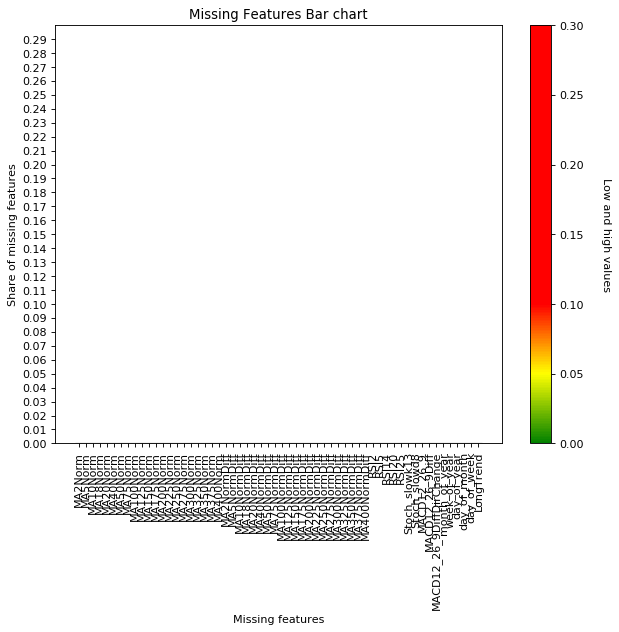

In [84]:
#Missing data part
print("Number of missing values per feature")
missingValueShare = []
for col in df_dig.columns:
    #if is_string_dtype(df_dig[col]):
    missingValueShare.append(sum(df_dig[col].isna())/numSamples)
        #print("Column {}: {}".format(col, round(sum(df[col]=='?')/numSamples, 3)))
    #else:
    #    missingValueShare.append(0)
        #print("Column {}: {}".format(col, 0))

#Print missing value graph
vis.paintBarChartForMissingValues(df_dig.columns, missingValueShare)

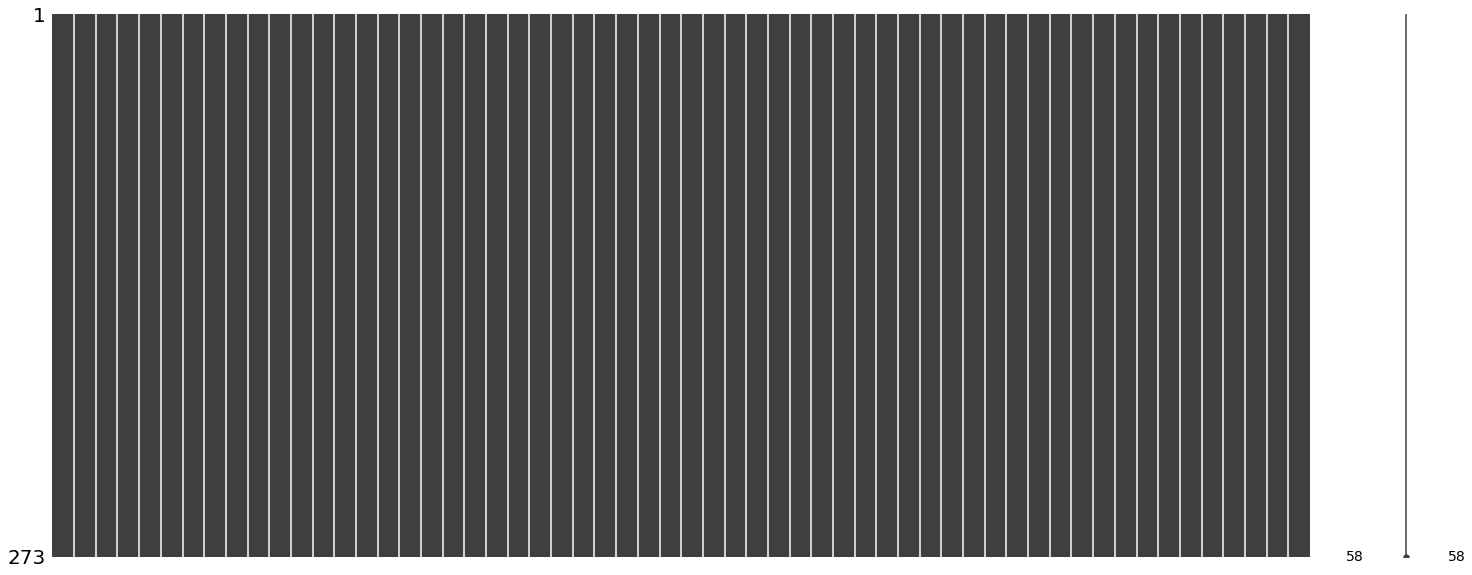

In [85]:
#Visualize missing data with missingno
import missingno as msno
%matplotlib inline
msno.matrix(df_dig)

In [86]:
if df.isnull().values.sum()>0:
    msno.heatmap(df_dig)

#### View Prepared Binary Features

We need some more plots for the binary data types.

In [87]:
#vis.plotBinaryValues(df_dig, df_dig.columns) #0:-1
#plt.savefig(image_save_directory + "/BinaryFeatures.png", dpi=70)

In [88]:
# Get feature data only
X_raw = df_dig.loc[:, df_dig.columns[0:-1]]

#X = df_raw.values[:,0:-1]
#X_labels = df_raw.columns[0:-1].values
#print("Original shape: {}, new shape without y values: {}".format(df_dig.values.shape, X.shape))
#print("X labels: {}".format(X.columns))
display(X_raw.head(2))

#y = df_raw.values[:,-1].reshape(-1, 1) #Important to do for the algorithms
y_raw = df_dig.loc[:, df_dig.columns[-1]]
y = y_raw.values.flatten()
#y_labels = class_labels
#class_labels_inverse = sup.inverse_dict(class_labels)

print("y shape: {}".format(y_raw.shape))
print("y labels: {}".format(class_labels))
print("y unique classes: {}".format(np.unique(y, axis=0)))

,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowk13,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,,,,,,,,,,,,,,,,,
400,-0.003522,-0.005992,-0.006573,-0.016782,-0.020412,-0.031975,-0.032452,-0.027211,-0.033875,-0.035074,...,84.707717,87.725927,31.673974,0.334551,0.0,8,32,219,7,1
401,-0.000844,-0.006427,-0.006441,-0.015985,-0.019097,-0.032834,-0.033579,-0.028324,-0.035232,-0.036156,...,89.005122,87.125064,31.945192,0.271218,0.0,8,32,220,8,2


y shape: (273,)
y labels: {0: 'negative', 1: 'positive'}
y unique classes: [0 1]


# Feature Visualization
Here, feature selection and visulization of datasets is performed
Methods
- Feature visualization through t-SNE
- Feature visualization and analysis through PCA

## Normalize Data for Feature Selection
Z-Normalize the data around zero and divided by standard deviation. Fit the normalizer on the training data and transform the training and the test data. The reason is that the scaler only must depend on the training data, in order to prevent leakage of information from the test data.

In [89]:
from sklearn import preprocessing

#=== Select the best type of scaler ===#
scaler = preprocessing.StandardScaler() #Because normal distribution. Don't use minmax scaler for PCA or unsupervised learning
# as the axis shall be centered and not shifted.


scaler.fit(X_raw)
#Use this scaler also for the test data at the end
X_scaled = pd.DataFrame(data=scaler.transform(X_raw), index = X_raw.index, columns=X_raw.columns)
print("Unscaled values")
display(X_raw.iloc[0:2,:])
print("Scaled values")
display(X_scaled.iloc[0:2,:])

Unscaled values


,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowk13,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,,,,,,,,,,,,,,,,,
400,-0.003522,-0.005992,-0.006573,-0.016782,-0.020412,-0.031975,-0.032452,-0.027211,-0.033875,-0.035074,...,84.707717,87.725927,31.673974,0.334551,0.0,8,32,219,7,1
401,-0.000844,-0.006427,-0.006441,-0.015985,-0.019097,-0.032834,-0.033579,-0.028324,-0.035232,-0.036156,...,89.005122,87.125064,31.945192,0.271218,0.0,8,32,220,8,2


Scaled values


,MA2Norm,MA5Norm,MA10Norm,MA18Norm,MA20Norm,MA40Norm,MA50Norm,MA75Norm,MA100Norm,MA125Norm,...,Stoch_slowk13,Stoch_slowd8,MACD12_26_9,MACD12_26_9Diff,MACD12_26_9DiffDirChange,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
id,,,,,,,,,,,,,,,,,,,,,
400,-0.742574,-0.546892,-0.409484,-0.764617,-0.876148,-0.984654,-0.918276,-0.646043,-0.730279,-0.726201,...,0.906995,1.175467,1.351035,0.118375,0.024959,0.415744,0.333399,0.328294,-0.992750,-0.720149
401,-0.182834,-0.585480,-0.401886,-0.730788,-0.823266,-1.009595,-0.948530,-0.671076,-0.758811,-0.748901,...,1.042383,1.153325,1.362234,0.099640,0.024959,0.415744,0.333399,0.338203,-0.877911,-0.010399


### Visualize Data with t-SNE

In [90]:
%%skip $skip_feature_analysis
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, X_scaled)

In [91]:
%%skip $skip_feature_analysis
from sklearn.manifold import TSNE
#%matplotlib notebook
#%matplotlib inline

np.random.seed(0)
#X_embedded = TSNE(n_components=2, perplexity=5.0, early_exaggeration=12.0, n_iter=5000, 
#                  n_iter_without_progress=1000, learning_rate=10).fit_transform(embedded)
X_embedded = TSNE(n_components=2, perplexity=10.0, early_exaggeration=100.0, n_iter=5000, 
                  n_iter_without_progress=1000, learning_rate=10).fit_transform(X_scaled.iloc[X_train_index_subset,:])

#### Plot t-SNE with best parameters

In [92]:
%matplotlib inline

In [93]:
%%skip $skip_feature_analysis
#Plot with texts added to the graphs

#from adjustText import adjust_text
targets = np.array(y[X_train_index_subset]).flatten()

plt.figure(figsize=(10,10))
texts = []
for i, t in enumerate(set(targets)):
    idx = targets == t
    #for x, y in zip(X_embedded[idx, 0], X_embedded[idx, 1]):
        #texts.append(plt.text(x, y, t))
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=class_labels[t])   

#adjust_text(texts, force_points=0.2, force_text=0.2, expand_points=(1,1), expand_text=(1,1), arrowprops=dict(arrowstyle="-", color='black', lw=0.5)) 

plt.legend(bbox_to_anchor=(1, 1));

#### t-SNE Parameter Grid Search

In [94]:
%%skip $skip_feature_analysis
from IPython.display import clear_output

#Optimize t-sne plot
tne_gridsearch = False

#Create a TSNE grid search with two variables
perplex = [5, 10, 30, 50, 100]
exaggregation = [5, 12, 20, 50, 100]
#learning_rate = [10, 50, 200]

fig, axarr = plt.subplots(len(perplex), len(exaggregation), figsize=(15,15))

if tne_gridsearch == True:
    #for m,l in enumerate(learning_rate):
    for k,p in enumerate(perplex):
        #print("i {}, p {}".format(i, p))
        for j,e in enumerate(exaggregation):
            #print("j {}, e {}".format(j, e))
            X_embedded = TSNE(n_components=2, perplexity=p, early_exaggeration=e, n_iter=5000, 
                              n_iter_without_progress=1000, learning_rate=10).fit_transform(X_scaled.iloc[X_train_index_subset,:])

            for i, t in enumerate(set(targets)):
                idx = targets == t
                axarr[k,j].scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=class_labels[t])

            axarr[k,j].set_title("p={}, e={}".format(p, e))
        
            clear_output(wait=True)
            print('perplex paramater={}/{}, exaggregation parameterj={}/{}'.format(k, len(perplex), j, len(exaggregation)))
        
fig.subplots_adjust(hspace=0.3)

### UMAP Cluster Analysis
Use a supervised/unsupervised analysis to make the clusters

In [95]:
%%skip $skip_feature_analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='poster')

import umap

#%time #Time of the whole cell
embeddingUnsupervised = umap.UMAP(n_neighbors=5).fit_transform(X_scaled)
#%time #Time of the whole cell
embeddingSupervised = umap.UMAP(n_neighbors=5).fit_transform(X_scaled, y=y)

In [96]:
%%skip $skip_feature_analysis
vis.plotUmap(embeddingUnsupervised, y, list(class_labels.values()), 'Dataset unsupervised clustering', cmapString='RdYlGn')
vis.plotUmap(embeddingSupervised, y, list(class_labels.values()), 'Dataset supervised clustering')

### PCA Analysis

In [97]:
%%skip $skip_feature_analysis
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

pca_trafo = PCA().fit(X_scaled);
pca_values = pca_trafo.transform(X_scaled)
#from adjustText import adjust_text
targets = np.array(y).flatten()

fig, ax1 = plt.subplots(figsize=(10, 8))
plt.semilogy(pca_trafo.explained_variance_ratio_, '--o');
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.semilogy(pca_trafo.explained_variance_ratio_.cumsum(), '--o', color='green');
plt.xlabel("Principal Component")
plt.ylabel("Explained variance")
plt.xticks(np.arange(0, len(pca_trafo.explained_variance_ratio_)))
plt.hlines(0.95, 0, len(pca_trafo.explained_variance_ratio_.cumsum()), colors='red', linestyles='solid', label='95% variance covered')

fig = plt.figure()
sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(X_scaled.shape[1]))), cmap="hot", cbar=True)

necessary_components = pca_trafo.explained_variance_ratio_.cumsum()[pca_trafo.explained_variance_ratio_.cumsum()<0.95]
print("95% variance covered with the {} first components. Values={}". format(len(necessary_components), necessary_components))

plt.figure(figsize=(10,10))
#plt.scatter(pca_values[:,0], pca_values[:,1], c=targets, edgecolor='none', label=class_labels.values(), alpha=0.5)
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(pca_values[idx, 0], pca_values[idx, 1], label=class_labels[t], edgecolor='none', alpha=0.5)  

plt.legend(labels=class_labels.values(), bbox_to_anchor=(1, 1));
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Feature Selection

In [98]:
#Select a random subset to visualize
import random

#Reduce the training set with the number of samples randomly chosen
X_train_index_subset = sup.get_data_subset_index(1000, X_scaled)

relevantFeatureList = []
selected_feature_list = pd.DataFrame()

No change of data. Size remains  273
Created a training subset


### Lasso Feature Selection

In [99]:
%%skip $skip_feature_selection
#%matplotlib inline
from sklearn.linear_model import LassoCV

def execute_lasso_feature_selection(X_scaled, y):
    reg = LassoCV(cv=10, max_iter = 100000)
    reg.fit(X_scaled, y)
    coef = pd.Series(reg.coef_, index = X_scaled.columns)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" %reg.score(X_scaled,y))
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    imp_coef = coef.sort_values()
    coefList = list(imp_coef[imp_coef!=0].index)
    print(coefList)

    #plt.figure()
    m.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()
    
    return coefList
    
#if do_feature_analysis==True:
coefList = execute_lasso_feature_selection(X_scaled, y)
selected_feature_list = selected_feature_list.append(pd.Series(name='Lasso', data=coefList))
relevantFeatureList.extend(coefList)

### Tree based feature selection

In [100]:
%%skip $skip_feature_selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

def execute_treebased_feature_selection(X_scaled, y):
    clf = ExtraTreesClassifier(n_estimators=50)
    clf = clf.fit(X_scaled, y)
    print(clf.feature_importances_) 
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X_scaled)
    X_new.shape

    threshold = 0.010
    tree_coef = pd.Series(clf.feature_importances_, index = X_scaled.columns)

    print("Tree search picked " + str(sum(tree_coef >= threshold)) + " variables and eliminated the other " +  str(sum(tree_coef < threshold)) + " variables")
    imp_treecoef = tree_coef.sort_values()
    treecoefList = list(imp_treecoef[imp_treecoef>threshold].index)
    print(treecoefList)

    plt.figure()
    m.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_treecoef.plot(kind = "barh")
    plt.title("Feature importance using Tree Search Model")
    plt.vlines(threshold, 0, len(X_scaled.columns), color='red')
    plt.show()
    
    return treecoefList

#if do_feature_analysis==True:
treecoefList = execute_treebased_feature_selection(X_scaled, y)
selected_feature_list = selected_feature_list.append(pd.Series(name='Tree', data=treecoefList))
relevantFeatureList.extend(treecoefList)

### Backward Elimination

In [101]:
%%skip $skip_feature_selection
#Backward Elimination - Wrapper method
import statsmodels.api as sm

def execute_backwardelimination_feature_selection(X_scaled, y):
    cols = list(X_scaled.columns)
    pmax = 1
    while (len(cols)>0):
        p= []
        X_1 = X_scaled[cols]
        X_1 = sm.add_constant(X_1)
        model = sm.OLS(y,X_1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)      
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
    selected_features_BE = cols

    print(selected_features_BE)
    print("\nNumber of features={}. Original number of features={}\n".format(len(selected_features_BE), len(X_scaled.columns)))
    [print("column {} removed".format(x)) for x in X_scaled.columns if x not in selected_features_BE]
    print("Finished")
    
    return selected_features_BE

#if do_feature_analysis==True:
selected_features_BE = execute_backwardelimination_feature_selection(X_scaled, y)
relevantFeatureList.extend(selected_features_BE)
selected_feature_list = selected_feature_list.append(pd.Series(name='Backward_Elimination', data=selected_features_BE))

### Recursive Elimination with Logistic Regression

In [102]:
%%skip $skip_feature_selection
#Recursive Elimination - Wrapper method, Feature ranking with recursive feature elimination
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE

def execute_recursive_elimination_feature_selection(X_scaled, y):
    model = LogisticRegressionCV(solver='liblinear', cv=3)
    print("Start Recursive Elimination. Fit model with {} examples.".format(X_scaled.shape[0]))
    #Initializing RFE model, 3 features selected
    rfe = RFE(model, 1) #It has to be one to get a unique index
    #Transforming data using RFE
    X_rfe = rfe.fit_transform(X_scaled,y)
    #Fitting the data to model
    model.fit(X_rfe,y)

    print("Best accuracy score using built-in Logistic Regression: ", model.score(X_rfe, y))
    print("Ranking")
    rfe_coef = pd.Series(X_scaled.columns, index = rfe.ranking_-1).sort_index()
    print(rfe_coef)
    print("Select columns")

    
    print(X_scaled.columns[rfe.support_].values)
    
    return X_scaled.columns[rfe.support_].values, rfe_coef

#if do_feature_analysis==True:
relevant_features, rfe_coef = execute_recursive_elimination_feature_selection(X_scaled.iloc[X_train_index_subset], y[X_train_index_subset])
relevantFeatureList.extend(relevant_features)

step_size = np.round(len(X_scaled.columns)/4,0).astype("int")
for i in range(step_size, len(X_scaled.columns), step_size):
    selected_feature_list = selected_feature_list.append(pd.Series(name='RecursiveTop' + str(i), data=rfe_coef.loc[0:i-1]))
    print('Created RecursiveTop{}'.format(str(i)))

In [103]:
#rfe_coef.loc[0:10].values

### Weighted values

In [104]:
#Weights
values, counts = np.unique(relevantFeatureList, return_counts=True)
s = pd.Series(index=values, data=counts).sort_values(ascending=False)
print(s)

Series([], dtype: int64)


### Add Manually Selected Subset

In [105]:
#print subset
newval = [x for x, c in zip(values, counts) if c>1]
subsetColumns = newval#X.columns[rfe.support_].values #list(values)
display(subsetColumns)
selected_feature_list = selected_feature_list.append(pd.Series(name='Manual', data=subsetColumns))

[]

### Add all columns

In [106]:
selected_feature_list = selected_feature_list.append(pd.Series(name='All', data=X_scaled.columns))

In [107]:
#subsetColumns = X.columns[rfe.support_].values
#X_subset = X_raw[subsetColumns]
#display(X_subset.head(5))
selected_feature_list.transpose()

,Manual,All
0,NaN,MA2Norm
1,NaN,MA5Norm
2,NaN,MA10Norm
3,NaN,MA18Norm
4,NaN,MA20Norm
5,NaN,MA40Norm
6,NaN,MA50Norm
7,NaN,MA75Norm
8,NaN,MA100Norm
9,NaN,MA125Norm


## Save Subset

In [108]:
import csv

#Save features to a csv file
print("Original features shape={}, features shape {}".format(df.shape, X_raw.shape))
X_raw.to_csv(X_filename, sep=';', index=True)
#np.savetxt(filenameprefix + "_X.csv", X, delimiter=";", fmt='%s')
print("Saved features to " + X_filename)

#Save y to a csv file
print("y shape {}".format(y.shape))
y_raw.to_csv(y_filename, sep=';', index=True, header=True)
print("Saved features to " + y_filename)

#Save y labels to a csv file as a dict
#print("Class labels length {}".format(len(y_labels)))
#with open(ylabel_filename, 'w') as f:
#    for key in y_labels.keys():
#        f.write("%s;%s\n"%(key,y_labels[key]))
#print("Saved class names and id to " + ylabel_filename)

#Save x subset column names to a csv file as a list
selected_feature_list.transpose().to_csv(X_filename_selected_feature_column, sep=';', index=False, header=True)
#print("Selected columns length {}".format(len(subsetColumns)))
#with open(X_filename_selected_feature_column, 'w') as f:
#    for item in subsetColumns:
#        f.write("%s\n"%(item))
print("Saved selected feature columns to " + X_filename_selected_feature_column)

print("=== Data for {} prepared to be trained ===". format(filenameprefix))

Original features shape=(273, 58), features shape (273, 57)
Saved features to 03_Test_Prepared_Data/omxs30_test_X.csv
y shape (273,)
Saved features to 03_Test_Prepared_Data/omxs30_test_y_LongTrend.csv
Saved selected feature columns to 03_Test_Prepared_Data/omxs30_test_X_selected_feature_columns.csv
=== Data for omxs30_test prepared to be trained ===


## Debug and Experiment

Best parameter (CV score=0.919):
{'logistic__alpha': 0.01, 'pca__n_components': 64}


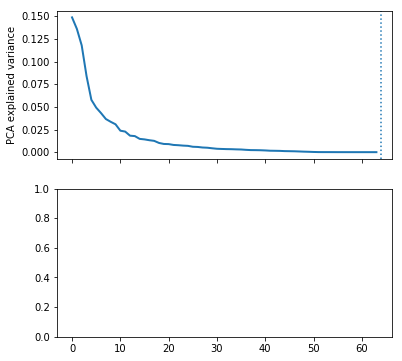

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True,
                         max_iter=10000, tol=1e-5, random_state=0)
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [5, 20, 30, 40, 50, 64],
    'logistic__alpha': np.logspace(-4, 4, 5),
}
search = GridSearchCV(pipe, param_grid, iid=False, cv=5)
search.fit(X_digits, y_digits)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

In [110]:
from tqdm import tqdm
import time
%matplotlib inline

pbar = tqdm(total=100)
for i in range(10):
    time.sleep(0.1)
    pbar.update(10)
pbar.close()

100%|██████████| 100/100 [00:01<00:00, 98.45it/s]


In [111]:
from statsmodels import robust

a = np.matrix( [
    [ 80, 76, 77, 78, 79, 81, 76, 77, 79, 84, 75, 79, 76, 78 ],
    [ 66, 69, 76, 72, 79, 77, 74, 77, 71, 79, 74, 66, 67, 73 ]
    ], dtype=float )
robust.mad(a, axis=1)

array([2.224, 5.189])

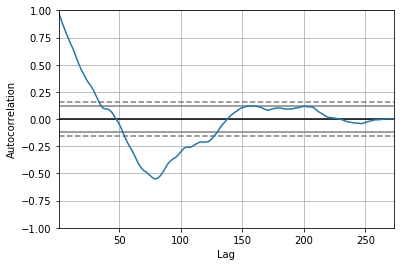

In [112]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_timegraph['Close'])
plt.show()